In [13]:
import sys
import os
import torch

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='3'

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from equivariant_pose_graph.utils.color_utils import color_gradient

from pytorch3d.transforms import Transform3d, Rotate, Translate

from tqdm import tqdm

plt.close('all')

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def toDisplay(x, target_dim = None):
    while(target_dim is not None and x.dim() > target_dim):
        x = x[0]
    return x.detach().cpu().numpy()

In [3]:
from pytorch3d.transforms import Transform3d,Rotate, rotation_6d_to_matrix, se3_exp_map
from equivariant_pose_graph.utils.se3 import *
from equivariant_pose_graph.utils.display import *
from equivariant_pose_graph.dataset.point_cloud_dataset import PointCloudDataset

In [4]:
from equivariant_pose_graph.models.transformer_flow import ResidualFlow_DiffEmbTransformer
from equivariant_pose_graph.models.multimodal_transformer_flow import Multimodal_ResidualFlow_DiffEmbTransformer, Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_eval_init import EquivarianceTestingModule
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_multimodal import EquivarianceTrainingModule, EquivarianceTrainingModule_WithPZCondX

#### Joint training ######

# gumbel 0.01
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-08_131543/residual_flow_occlusion/2v2mdz1q/checkpoints/epoch_79_global_step_20000.ckpt"
# gumbel 2
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-08_104404/residual_flow_occlusion/1b75l9xs/checkpoints/epoch_247_global_step_62000.ckpt"
# gumbel 5
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-08_173907/residual_flow_occlusion/1jbwidxv/checkpoints/epoch_175_global_step_44000.ckpt"
# gumbel 10
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-08_104555/residual_flow_occlusion/2nnowjxz/checkpoints/epoch_119_global_step_30000.ckpt"
# gumbel 20
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-02-08_173924/residual_flow_occlusion/2qhjpn28/checkpoints/epoch_87_global_step_22000.ckpt"

# last p(z|X) on frozen p(z|Y)
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-01-24_122703/residual_flow_occlusion/1xjwly3u/checkpoints/epoch_887_global_step_222000.ckpt"



place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/data/merged_3_step_train_earlierckpt.ckpt"



inner_network = ResidualFlow_DiffEmbTransformer(
                    emb_nn='dgcnn', return_flow_component=True, center_feature=True,
                    inital_sampling_ratio=1, input_dims=4)
place_nocond_network = Multimodal_ResidualFlow_DiffEmbTransformer(
                    inner_network, gumbel_temp=0.5, center_feature=True)
place_network = Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX(
                    place_nocond_network, encoder_type="2_dgcnn")
place_nocond_model = EquivarianceTrainingModule(
    place_nocond_network,
    lr=1e-4,
    image_log_period=100,
    weight_normalize='softmax', #'l1',
    softmax_temperature=1
)
place_model = EquivarianceTrainingModule_WithPZCondX(
    place_network,
    place_nocond_model,
)


place_model.cuda()
place_model.load_state_dict(torch.load(place_checkpoint_file)['state_dict']);

In [5]:
from torch.utils.data import DataLoader

MUG_ID = 0
# dataset = PointCloudDataset('/home/bokorn/src/ndf_robot/data/renders', 
# dataset = PointCloudDataset('/home/jwang/code/equivariant_pose_graph/data/bokorn_ndf_robot_data_duprack_bothmugrack/renders', 
# dataset = PointCloudDataset('/home/jwang/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders', 
# dataset = PointCloudDataset('/home/jwang/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders', 
dataset = PointCloudDataset('/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack_overfit/renders', 
                            cloud_type='teleport',
#                             cloud_type='init',
                            dataset_indices=[MUG_ID])
#                             dataset_indices=[3])
dataloader = DataLoader(dataset)

/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack_overfit/renders/0_teleport_obj_points.npz


In [6]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence

fig = go.FigureWidget(
        make_subplots(
            column_widths=[0.5, 0.5],
            row_heights=[1],#[0.5, 0.5],
            rows=1, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}]],
        )
    )

fig.add_trace(
    go.Scatter3d(
        x = action_pts[:,0], 
        y = action_pts[:,1], 
        z = action_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

fig.add_trace(
    go.Scatter3d(
        x = anchor_pts[:,0], 
        y = anchor_pts[:,1], 
        z = anchor_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

# scatter_post_action = fig.data[-1]
# scatter_post_action.marker.size = 1
# scatter_post_action.marker.opacity = 0.5
# scatter_post_action.marker.color = '#9467bd'
# remove_background(fig)



fig

NameError: name 'action_pts' is not defined

In [ ]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence
from equivariant_pose_graph.utils.color_utils import color_gradient


fig = go.FigureWidget(
        make_subplots(
            column_widths=[0.5, 0.5],
            row_heights=[1],#[0.5, 0.5],
            rows=1, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}]],
        )
    )

fig.add_trace(
    go.Scatter3d(
        x = post_action_pts[:,0], 
        y = post_action_pts[:,1], 
        z = post_action_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)
# fig.add_trace(
#     go.Scatter3d(
#         x = anchor_trans_pts[:,0], 
#         y = anchor_trans_pts[:,1], 
#         z = anchor_trans_pts[:,2], 
#         mode = 'markers',
#         hoverinfo = 'none',
#     ), 
#     row=1,col=1
# )

fig.add_trace(
    go.Scatter3d(
        x = action_trans_pts[:,0], 
        y = action_trans_pts[:,1], 
        z = action_trans_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=2
)
# fig.add_trace(
#     go.Scatter3d(
#         x = post_anchor_pts[:,0], 
#         y = post_anchor_pts[:,1], 
#         z = post_anchor_pts[:,2], 
#         mode = 'markers',
#         hoverinfo = 'none',
#     ), 
#     row=1,col=2
# )

goal_emb_action_colors = color_gradient(F.softmax(goal_emb_action[0], dim=-1))
goal_emb_cond_x_action_colors = color_gradient(F.softmax(goal_emb_cond_x_action[0], dim=-1))
    
goal_emb_anchor_colors = color_gradient(F.softmax(goal_emb_anchor[0], dim=-1))
goal_emb_cond_x_anchor_colors = color_gradient(F.softmax(goal_emb_cond_x_anchor[0], dim=-1))
    
fig.data[0].marker.color = goal_emb_action_colors #np.concatenate([goal_emb_action_colors[0], goal_emb_anchor_colors[0]])
fig.data[1].marker.color = goal_emb_cond_x_action_colors[0] #np.concatenate([goal_emb_cond_x_action_colors[0], goal_emb_cond_x_anchor_colors[0]])

fig

In [ ]:
from pytorch3d.transforms import Transform3d
from pytorch_lightning.utilities.seed import seed_everything

seed_everything(0)

for data in dataloader:
    points_action = data['points_action'].cuda()[:,:-2]
    points_anchor = data['points_anchor'].cuda()
    points_action_trans = data['points_action_trans'].cuda()[:,:-2]
    points_anchor_trans = data['points_anchor_trans'].cuda()
#     T0 = Transform3d(matrix=data['T0']).cuda()
#     T1 = Transform3d(matrix=data['T1']).cuda()

    from equivariant_pose_graph.utils.se3 import random_se3
#     T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
#     T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
    T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
    T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
    T1 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
    points_action_trans = T0.transform_points(points_action)
    points_anchor_trans = T1.transform_points(points_anchor)
    break

In [ ]:
error_R_mean = float("-inf")
i = 0
while i < 5 and error_R_mean < 90:
    vis_train = False
    
#     T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
#     T1 = random_se3(1, rot_var=180, trans_var=0.5).cuda()

    if vis_train:
        place_model.train()
        res = place_model.get_transform(points_action_trans, points_anchor_trans,  points_action, points_anchor)

        pred_T_action = res['pred_T_action']
        flow_action = res['flow_components']['flow_action'][:,:,:3]
        pred_w_action = torch.sigmoid(res['flow_components']['flow_action'][:,:,3])
        flow_anchor = res['flow_components']['flow_anchor'][:,:,:3]
        pred_w_anchor = torch.sigmoid(res['flow_components']['flow_anchor'][:,:,3])
        corr_flow_action = res['flow_components']['corr_flow_action']
        corr_flow_anchor = res['flow_components']['corr_flow_anchor']
        corr_points_action = res['flow_components']['corr_points_action']
        corr_points_anchor = res['flow_components']['corr_points_anchor']
        residual_flow_action = res['flow_components']['residual_flow_action']
        residual_flow_anchor = res['flow_components']['residual_flow_anchor']
        action_attn = res['flow_components']['action_attn']
        anchor_attn = res['flow_components']['anchor_attn']
        goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
        goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]
        dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
        dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
        trans_pt_action = res['flow_components']['trans_pt_action']
        trans_pt_anchor = res['flow_components']['trans_pt_anchor']
        trans_sample_action = res['flow_components']['trans_sample_action']
        trans_sample_anchor = res['flow_components']['trans_sample_anchor']
        goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
        goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]
    else:
        place_model.eval()
        res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
        residual_flow_action = res['flow_components']['residual_flow_action']
        residual_flow_anchor = res['flow_components']['residual_flow_anchor']
        goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
        goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]

        res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
        pred_T_action = res['pred_T_action']
        flow_action = res['flow_components']['flow_action'][:,:,:3]
        pred_w_action = torch.sigmoid(res['flow_components']['flow_action'][:,:,3])
        flow_anchor = res['flow_components']['flow_anchor'][:,:,:3]
        pred_w_anchor = torch.sigmoid(res['flow_components']['flow_anchor'][:,:,3])
        corr_flow_action = res['flow_components']['corr_flow_action']
        corr_flow_anchor = res['flow_components']['corr_flow_anchor']
        corr_points_action = res['flow_components']['corr_points_action']
        corr_points_anchor = res['flow_components']['corr_points_anchor']
        residual_flow_action = res['flow_components']['residual_flow_action']
        residual_flow_anchor = res['flow_components']['residual_flow_anchor']
        action_attn = res['flow_components']['action_attn']
        anchor_attn = res['flow_components']['anchor_attn']
        dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
        dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
        trans_pt_action = res['flow_components']['trans_pt_action']
        trans_pt_anchor = res['flow_components']['trans_pt_anchor']
        trans_sample_action = res['flow_components']['trans_sample_action']
        trans_sample_anchor = res['flow_components']['trans_sample_anchor']
        goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
        goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


    #####

    post_action_pts = toDisplay(pred_T_action.transform_points(points_action_trans))[0]
    post_anchor_pts = toDisplay(pred_T_action.inverse().transform_points(points_anchor_trans))[0]

    action_pts = toDisplay(points_action)[0]
    anchor_pts = toDisplay(points_anchor)[0]
    action_trans_pts = toDisplay(points_action_trans)[0]
    anchor_trans_pts = toDisplay(points_anchor_trans)[0]
    action_flow = toDisplay(flow_action)[0]
    action_flow_corr = toDisplay(corr_flow_action)[0]
    action_flow_res = toDisplay(residual_flow_action)[0]
    anchor_flow = toDisplay(flow_anchor)[0]
    # vis_scores = toDisplay(scores)[0]
    vis_attn_act = toDisplay(action_attn)[0]
    vis_attn_anc = toDisplay(anchor_attn)[0]
    action_w = toDisplay(pred_w_action)[0]
    anchor_w = toDisplay(pred_w_anchor)[0]

    ####

    from equivariant_pose_graph.utils.visualizations import visualize_correspondence

    fig = visualize_correspondence(action_trans_pts, anchor_trans_pts, vis_attn_act, action_flow, 
                                   weights = action_w, skip=50)
    fig.add_trace(
        go.Scatter3d(
            x = post_action_pts[:,0], 
            y = post_action_pts[:,1], 
            z = post_action_pts[:,2], 
            mode = 'markers',
            hoverinfo = 'none',
        ), 
        row=1,col=1
    )

    scatter_post_action = fig.data[-1]
    scatter_post_action.marker.size = 1
    scatter_post_action.marker.opacity = 0.5
    # scatter_post_action.marker.color = '#9467bd'
    # remove_background(fig)

    error_R_max, error_R_min, error_R_mean = get_degree_angle(T0.inverse().compose(
                T1).compose(pred_T_action.inverse()))
    error_t_max, error_t_min, error_t_mean = get_translation(T0.inverse().compose(
                T1).compose(pred_T_action.inverse()))
#     error_R_max0, error_R_min0, error_R_mean0 = get_degree_angle(T0.inverse().compose(
#                 T1).compose(pred_T_action.inverse()))
#     error_t_max0, error_t_min0, error_t_mean0 = get_translation(T0.inverse().compose(
#                 T1).compose(pred_T_action.inverse()))
#     error_R_max1, error_R_min1, error_R_mean1 = get_degree_angle(T0.inverse().translate(0.3, 0, 0).compose(
#                 T1).compose(pred_T_action.inverse()))
#     error_R_max2, error_R_min2, error_R_mean2 = get_degree_angle(T0.inverse().translate(-0.3, 0, 0).compose(
#                 T1).compose(pred_T_action.inverse()))
#     error_t_max1, error_t_min1, error_t_mean1 = get_translation(T0.inverse().translate(0.3, 0, 0).compose(
#                 T1.compose(pred_T_action.inverse())))
#     error_t_max2, error_t_min2, error_t_mean2 = get_translation(T0.inverse().translate(-0.3, 0, 0).compose(
#                             T1.compose(pred_T_action.inverse())))
#     error_R_mean = min(error_R_mean0, error_R_mean1, error_R_mean2)
#     error_t_mean = min(error_t_mean0, error_t_mean1, error_t_mean2)

    print(f"Mug #{MUG_ID}: error R mean={error_R_mean:.2f}, error t mean={error_t_mean:.2f}")
    
    i += 1



    fig.show()

In [7]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence

fig = visualize_correspondence(action_trans_pts, anchor_trans_pts, vis_attn_act, action_flow, 
                               weights = action_w, skip=50)
fig.add_trace(
    go.Scatter3d(
        x = post_action_pts[:,0], 
        y = post_action_pts[:,1], 
        z = post_action_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

scatter_post_action = fig.data[-1]
scatter_post_action.marker.size = 1
scatter_post_action.marker.opacity = 0.5
# scatter_post_action.marker.color = '#9467bd'
# remove_background(fig)

print(f"Test mug #{MUG_ID}")
fig

NameError: name 'action_trans_pts' is not defined

## Add mug_id to a dataset

In [75]:
# import os
# dataset_dir = '/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders'
# for filename in os.listdir(dataset_dir):
#     full_path = f"{dataset_dir}/{filename}"
#     data = dict(np.load(full_path))
#     mug_id = filename.split("_")[0] # string
#     data["mug_id"] = mug_id
#     np.savez(full_path, **data)

# Rotation and error histograms

In [76]:
# import os
# dataset_dir = '/home/jwang/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders'
# mug_ids = [int(filename.split("_")[0]) for filename in os.listdir(dataset_dir) if filename[:3] != "999"]
# mug_ids.sort()

# print(mug_ids)

In [10]:
print("Joint then KL + gumbel temp 2 + train 1 (from p(z|Y) only run) #2")
from collections import defaultdict
R_errors_per_mug = defaultdict(list)
t_errors_per_mug = defaultdict(list)
from torch.utils.data import DataLoader

from equivariant_pose_graph.utils.error_metrics import get_2rack_errors, print_rack_errors

get_rack_errors = get_2rack_errors

configs = [
    {
        'title': "Train mugs' errors when sampling p(z|Y)",
        'name': "trainmug_trainforward_per_mug",
        'dataset_dir': '/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
        'vis_train': True
    },
    {
        'title': "Train mugs' errors when sampling p(z|X)",
        'name': "trainmug_testforward_per_mug",
        'dataset_dir': '/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
        'vis_train': False
    },
#     {
#         'title': "Test mugs' errors when sampling p(z|Y)",
#         'name': "testmug_trainforward_per_mug",
#         'dataset_dir': '/home/jwang/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders',
#         'vis_train': True
#     },
#     {
#         'title': "Test mugs' errors when sampling p(z|X)",
#         'name': "testmug_testforward_per_mug",
#         'dataset_dir': '/home/jwang/code/equivariant_pose_graph/data/test_data_duprack_bothmugrack/renders',
#         'vis_train': False
#     },
]

# dict of dict of dict of lists
# results[config name][mug id][metric name] = [list of results]
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) 

for config in configs:
    dataset = PointCloudDataset(config['dataset_dir'], 
                                cloud_type='teleport',
                                dataset_indices='None',
                                num_demo=None,
                                dataset_size=len(os.listdir(config['dataset_dir'])),
                                random_files=False)
    dataloader = DataLoader(dataset)

    ###


    from pytorch3d.transforms import Transform3d
    from pytorch_lightning.utilities.seed import seed_everything

    seed_everything(0)

    # Ensure we go through all data in the dataset in order exactly once
    for i, _ in enumerate(tqdm(dataloader)):
        data = dataloader.dataset[i]

        points_action = data['points_action'].cuda()[None, :-2]
        points_anchor = data['points_anchor'].cuda()[None]
        points_action_trans = data['points_action_trans'].cuda()[None,:-2]
        points_anchor_trans = data['points_anchor_trans'].cuda()[None]

        mug_id = data['mug_id']
        mug_id_base = mug_id if not mug_id.startswith("999") else mug_id[3:]

        ###

        for i in range(25):
            T0 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
            T1 = random_se3(1, rot_var=180, trans_var=0.5).cuda()
            points_action_trans = T0.transform_points(points_action)
            points_anchor_trans = T1.transform_points(points_anchor)
            
            if config['vis_train']:
                place_model.train()
                res = place_model.get_transform(points_action_trans, points_anchor_trans,  points_action, points_anchor)

                pred_T_action = res['pred_T_action']
                flow_action = res['flow_components']['flow_action'][:,:,:3]
                pred_w_action = torch.sigmoid(res['flow_components']['flow_action'][:,:,3])
                flow_anchor = res['flow_components']['flow_anchor'][:,:,:3]
                pred_w_anchor = torch.sigmoid(res['flow_components']['flow_anchor'][:,:,3])
                corr_flow_action = res['flow_components']['corr_flow_action']
                corr_flow_anchor = res['flow_components']['corr_flow_anchor']
                corr_points_action = res['flow_components']['corr_points_action']
                corr_points_anchor = res['flow_components']['corr_points_anchor']
                residual_flow_action = res['flow_components']['residual_flow_action']
                residual_flow_anchor = res['flow_components']['residual_flow_anchor']
                action_attn = res['flow_components']['action_attn']
                anchor_attn = res['flow_components']['anchor_attn']
                goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
                goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]
                dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
                dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
                trans_pt_action = res['flow_components']['trans_pt_action']
                trans_pt_anchor = res['flow_components']['trans_pt_anchor']
                trans_sample_action = res['flow_components']['trans_sample_action']
                trans_sample_anchor = res['flow_components']['trans_sample_anchor']
                goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
                goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]
            else:
                place_model.eval()
                res = place_model.training_module_no_cond_x.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
                residual_flow_action = res['flow_components']['residual_flow_action']
                residual_flow_anchor = res['flow_components']['residual_flow_anchor']
                goal_emb_action = res['flow_components']['goal_emb'][:, :, :residual_flow_action.shape[1]]
                goal_emb_anchor = res['flow_components']['goal_emb'][:, :, residual_flow_action.shape[1]:]

                res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action, points_anchor)
                pred_T_action = res['pred_T_action']
                flow_action = res['flow_components']['flow_action'][:,:,:3]
                pred_w_action = torch.sigmoid(res['flow_components']['flow_action'][:,:,3])
                flow_anchor = res['flow_components']['flow_anchor'][:,:,:3]
                pred_w_anchor = torch.sigmoid(res['flow_components']['flow_anchor'][:,:,3])
                corr_flow_action = res['flow_components']['corr_flow_action']
                corr_flow_anchor = res['flow_components']['corr_flow_anchor']
                corr_points_action = res['flow_components']['corr_points_action']
                corr_points_anchor = res['flow_components']['corr_points_anchor']
                residual_flow_action = res['flow_components']['residual_flow_action']
                residual_flow_anchor = res['flow_components']['residual_flow_anchor']
                action_attn = res['flow_components']['action_attn']
                anchor_attn = res['flow_components']['anchor_attn']
                dense_trans_pt_action = res['flow_components']['dense_trans_pt_action']
                dense_trans_pt_anchor = res['flow_components']['dense_trans_pt_anchor']
                trans_pt_action = res['flow_components']['trans_pt_action']
                trans_pt_anchor = res['flow_components']['trans_pt_anchor']
                trans_sample_action = res['flow_components']['trans_sample_action']
                trans_sample_anchor = res['flow_components']['trans_sample_anchor']
                goal_emb_cond_x_action = res['flow_components']['goal_emb_cond_x'][:, :, :residual_flow_action.shape[1]]
                goal_emb_cond_x_anchor = res['flow_components']['goal_emb_cond_x'][:, :, residual_flow_action.shape[1]:]


            #####

            post_action_pts = toDisplay(pred_T_action.transform_points(points_action_trans))[0]
            post_anchor_pts = toDisplay(pred_T_action.inverse().transform_points(points_anchor_trans))[0]

            action_pts = toDisplay(points_action)[0]
            anchor_pts = toDisplay(points_anchor)[0]
            action_trans_pts = toDisplay(points_action_trans)[0]
            anchor_trans_pts = toDisplay(points_anchor_trans)[0]
            action_flow = toDisplay(flow_action)[0]
            action_flow_corr = toDisplay(corr_flow_action)[0]
            action_flow_res = toDisplay(residual_flow_action)[0]
            anchor_flow = toDisplay(flow_anchor)[0]
            # vis_scores = toDisplay(scores)[0]
            vis_attn_act = toDisplay(action_attn)[0]
            vis_attn_anc = toDisplay(anchor_attn)[0]
            action_w = toDisplay(pred_w_action)[0]
            anchor_w = toDisplay(pred_w_anchor)[0]

            ####


            # Old metric: for demo rack only
            error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="demo_rack", verbose=False)
            results[config['name']][mug_id_base]["demo_R_error"].append(error_R_mean)
            results[config['name']][mug_id_base]["demo_t_error"].append(error_t_mean)
            
            
            # Newish metric: take min across 2 racks
#             error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="bad_min_rack", verbose=False)
#             results[config['name']][mug_id_base]["badminrack_R_error"].append(error_R_mean)
#             results[config['name']][mug_id_base]["badminrack_t_error"].append(error_t_mean)
            
            # Newer metric: take min across 2 racks with batch stuff
            error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="batch_min_rack", verbose=False)
            results[config['name']][mug_id_base]["minrack_R_error"].append(error_R_mean)
            results[config['name']][mug_id_base]["minrack_t_error"].append(error_t_mean)





Joint then KL + gumbel temp 2 + train 1 (from p(z|Y) only run) #2
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99928_teleport_obj_points.npz


Global seed set to 0
100%|██████████| 24/24 [00:51<00:00,  2.13s/it]


/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99928_teleport_obj_points.npz


Global seed set to 0
100%|██████████| 24/24 [01:09<00:00,  2.89s/it]


In [11]:
def plot_errors(all_errors, title, error_type, fixed_xrange=False, ax=None, verbose=True):
    assert error_type in ["rotation", "translation"]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if verbose:
        print(f"Mean: {sum(all_errors)/len(all_errors):.2f}")

    ax.hist(all_errors)
    ax.set_title(title)
    ax.set_xlabel("R error" if error_type == "rotation" else "t error")
    ax.set_ylabel("Count")
    if fixed_xrange:
        if error_type == "rotation":
            ax.set_xlim(0, 180)
        elif error_type == "translation":
            ax.set_xlim(0, 0.5)


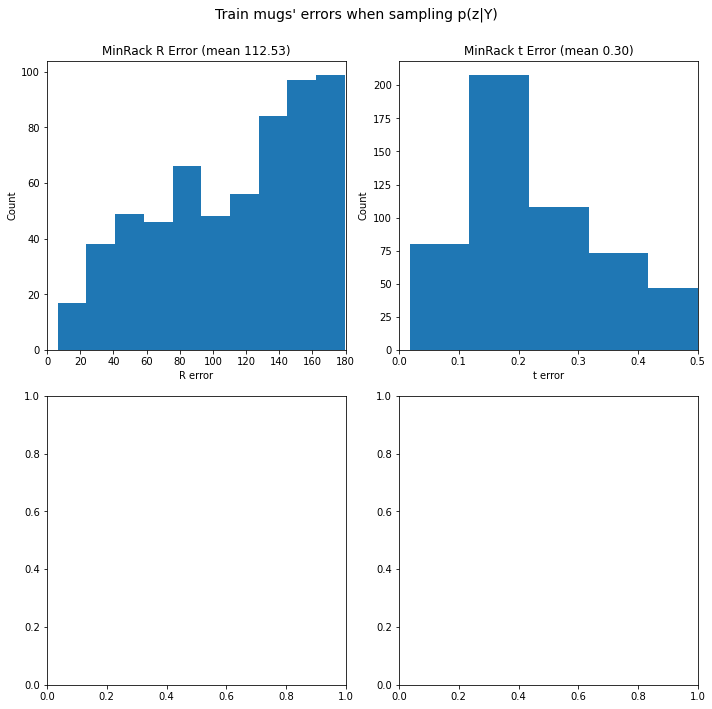

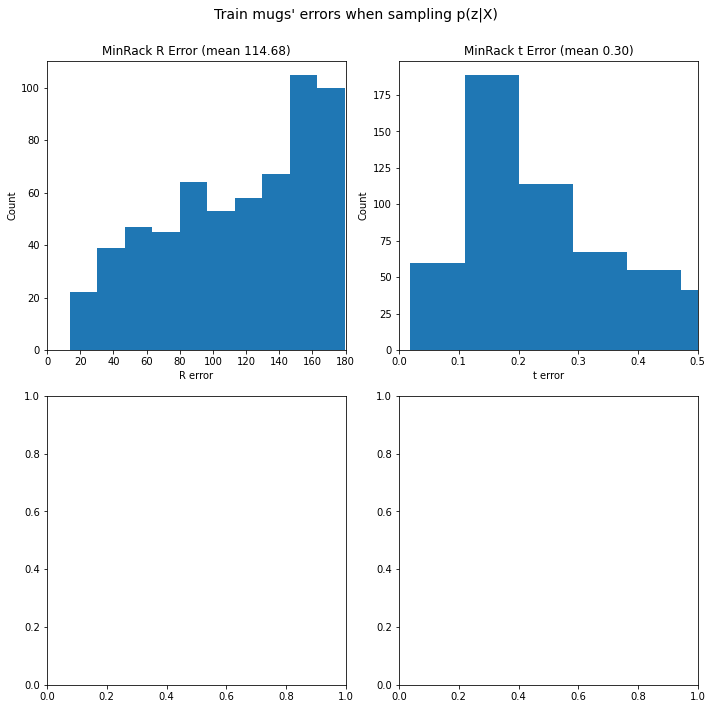

In [16]:
def plot_aggregates(configs, results, fixed_xrange=True):
    def aggregate_results_across_mugs(results, name, metric_name):
        assert name in results, f"Run type '{name}' doesn't exist. Use any of: {list(results.keys())}"
        sample_mug_id = list(results[name].keys())[0]
        assert metric_name in results[name][sample_mug_id], f"Metric name '{metric_name}' doesn't exist. Use any of: {list(results[name][sample_mug_id].keys())}"

        data = []
        for mug_id in results[name]:
            data.extend(results[name][mug_id][metric_name])
        return data
    
    for config in configs:
        fig, axs = plt.subplots(nrows=2, ncols=2)
        fig.set_figheight(10)
        fig.set_figwidth(10)

        fig.suptitle(f"{config['title']}\n", fontsize=14)

        all_errors = aggregate_results_across_mugs(results, config['name'], "minrack_R_error")
        plot_errors(
            all_errors=all_errors, 
            title=f"MinRack R Error (mean {sum(all_errors)/len(all_errors):.2f})",
            error_type="rotation",
            fixed_xrange=fixed_xrange,
            ax=axs[0][0],
            verbose=False,
        )
        all_errors = aggregate_results_across_mugs(results, config['name'], "minrack_t_error")
        plot_errors(
            all_errors=all_errors, 
            title=f"MinRack t Error (mean {sum(all_errors)/len(all_errors):.2f})",
            error_type="translation",
            fixed_xrange=fixed_xrange,
            ax=axs[0][1],
            verbose=False,
        )
#         all_errors = aggregate_results_across_mugs(results, config['name'], "demo_R_error")
#         plot_errors(
#             all_errors=all_errors, 
#             title=f"DemoRack R Error (mean {sum(all_errors)/len(all_errors):.2f})",
#             error_type="rotation",
#             fixed_xrange=fixed_xrange,
#             ax=axs[1][0],
#             verbose=False,
#         )
#         all_errors = aggregate_results_across_mugs(results, config['name'], "demo_t_error")
#         plot_errors(
#             all_errors=all_errors, 
#             title=f"DemoRack t Error (mean {sum(all_errors)/len(all_errors):.2f})",
#             error_type="translation",
#             fixed_xrange=fixed_xrange,
#             ax=axs[1][1],
#             verbose=False,
#         )
        fig.tight_layout()
    plt.show()

plot_aggregates(configs, results)


## Plotting errors by mug


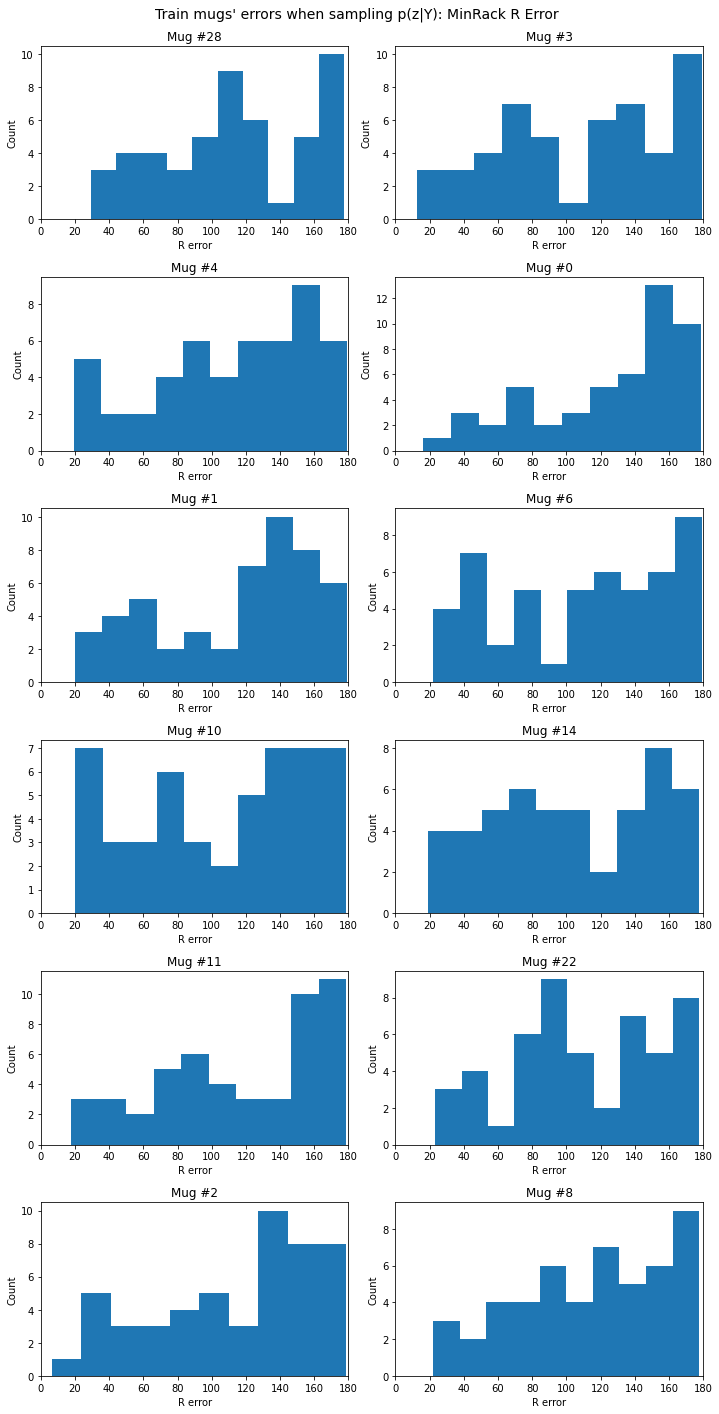

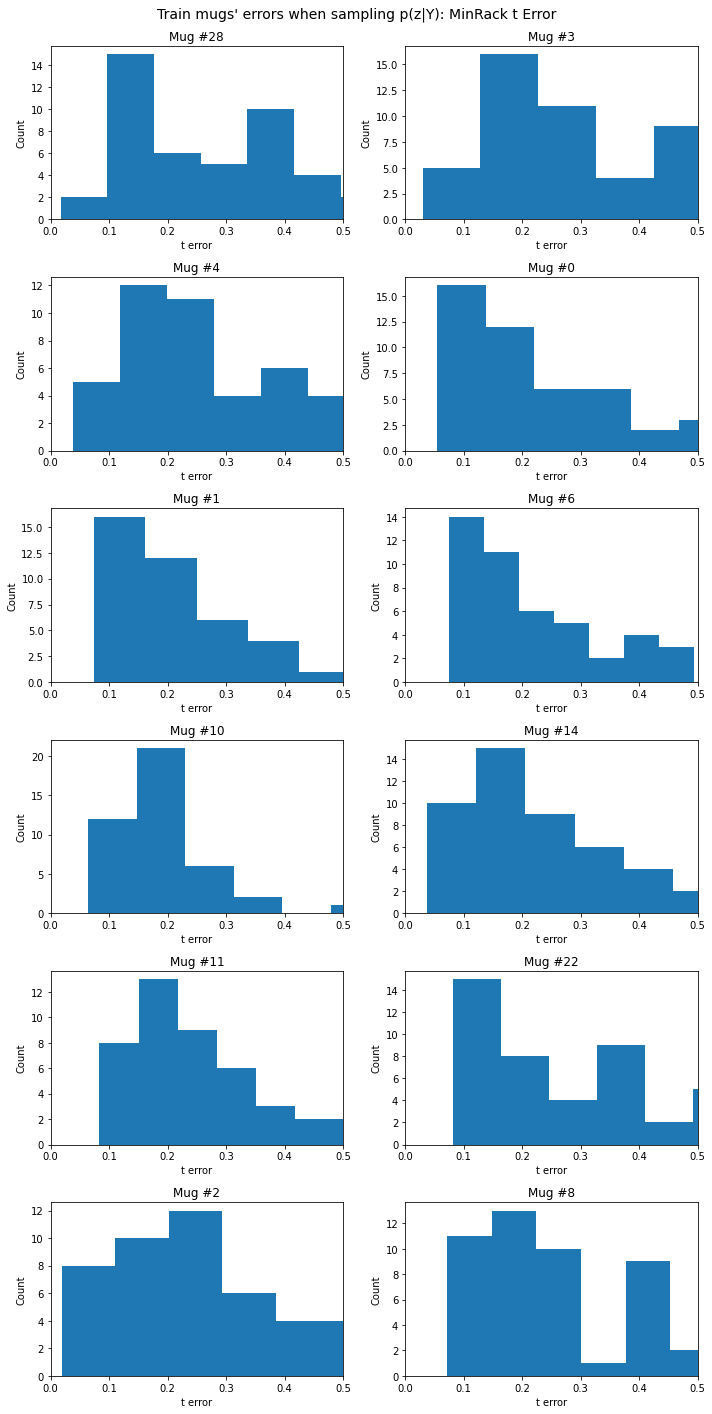

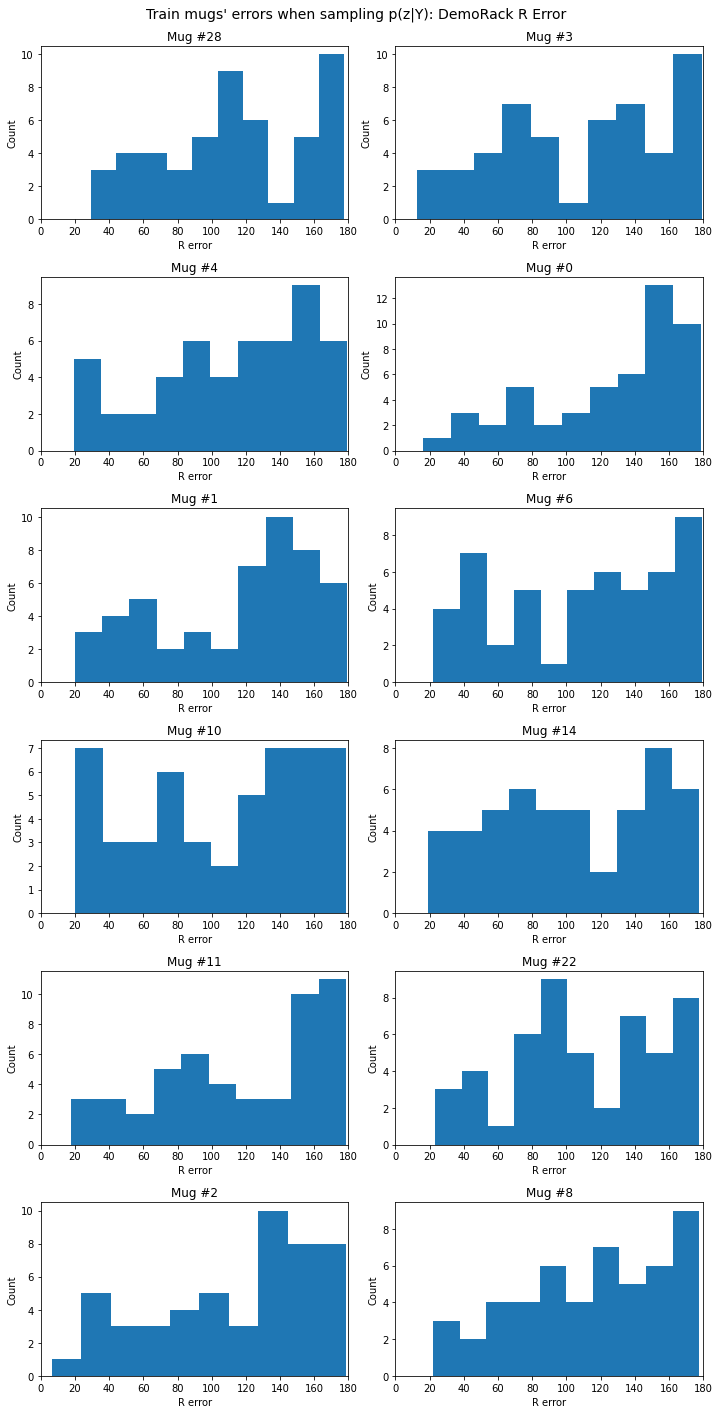

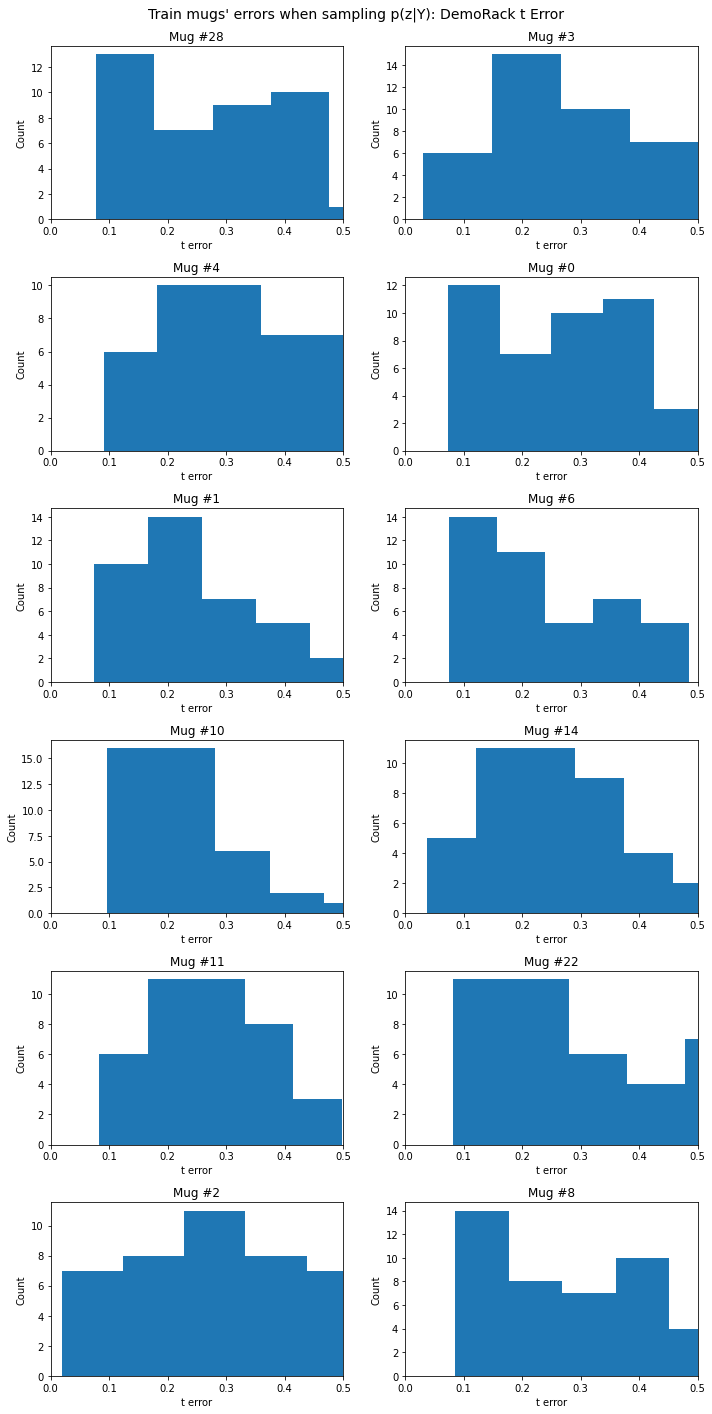

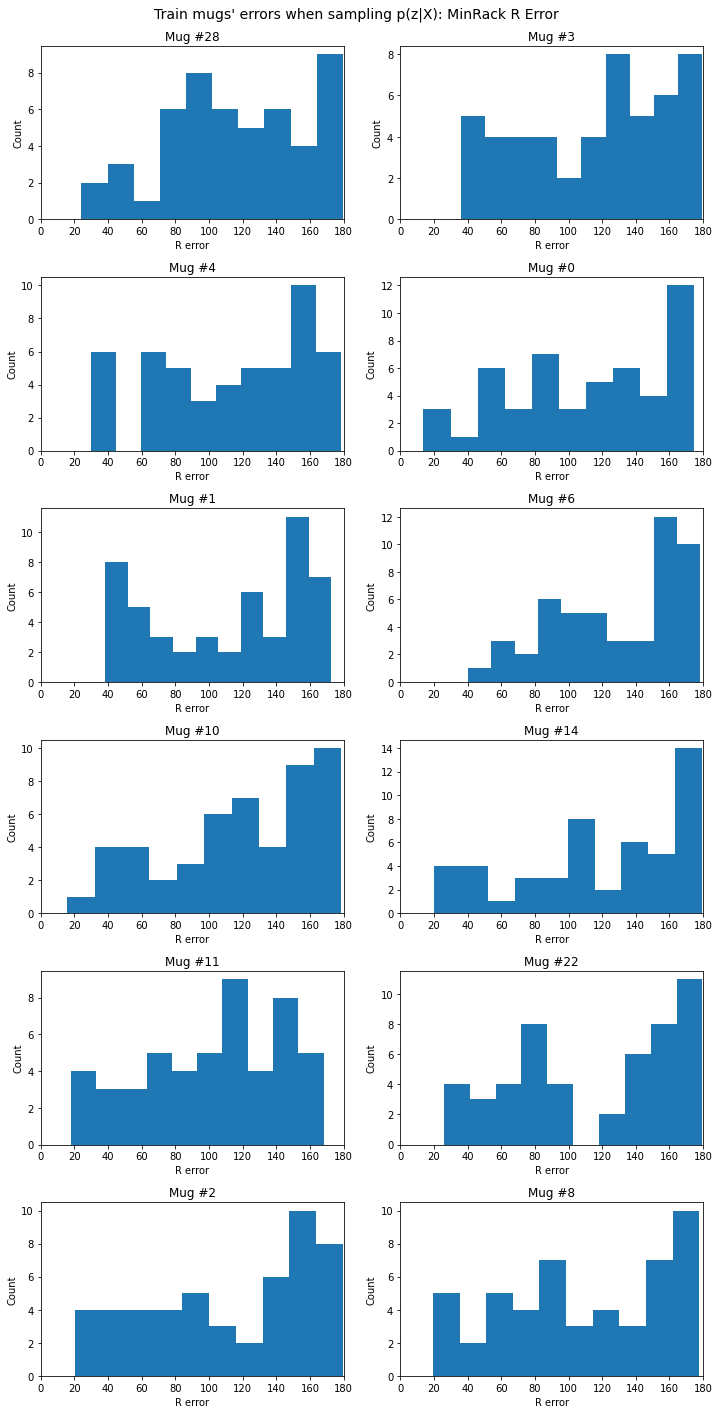

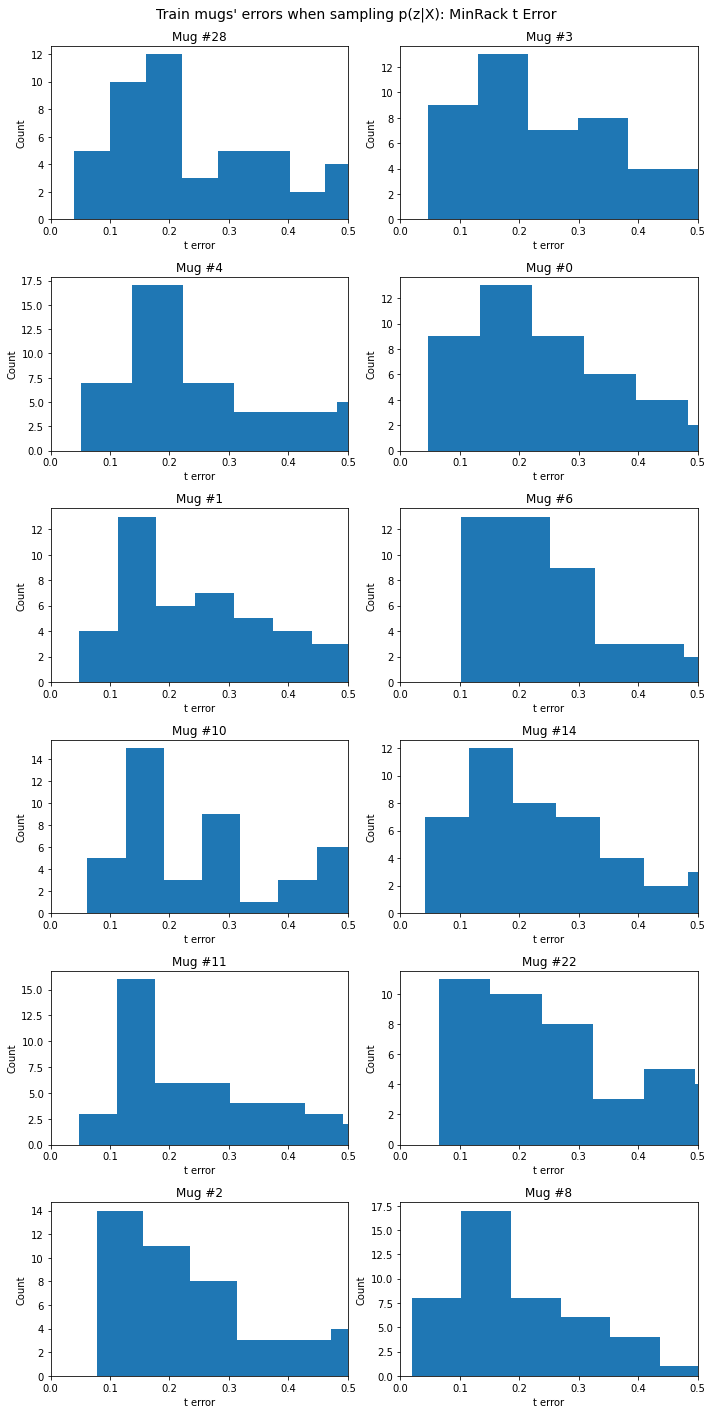

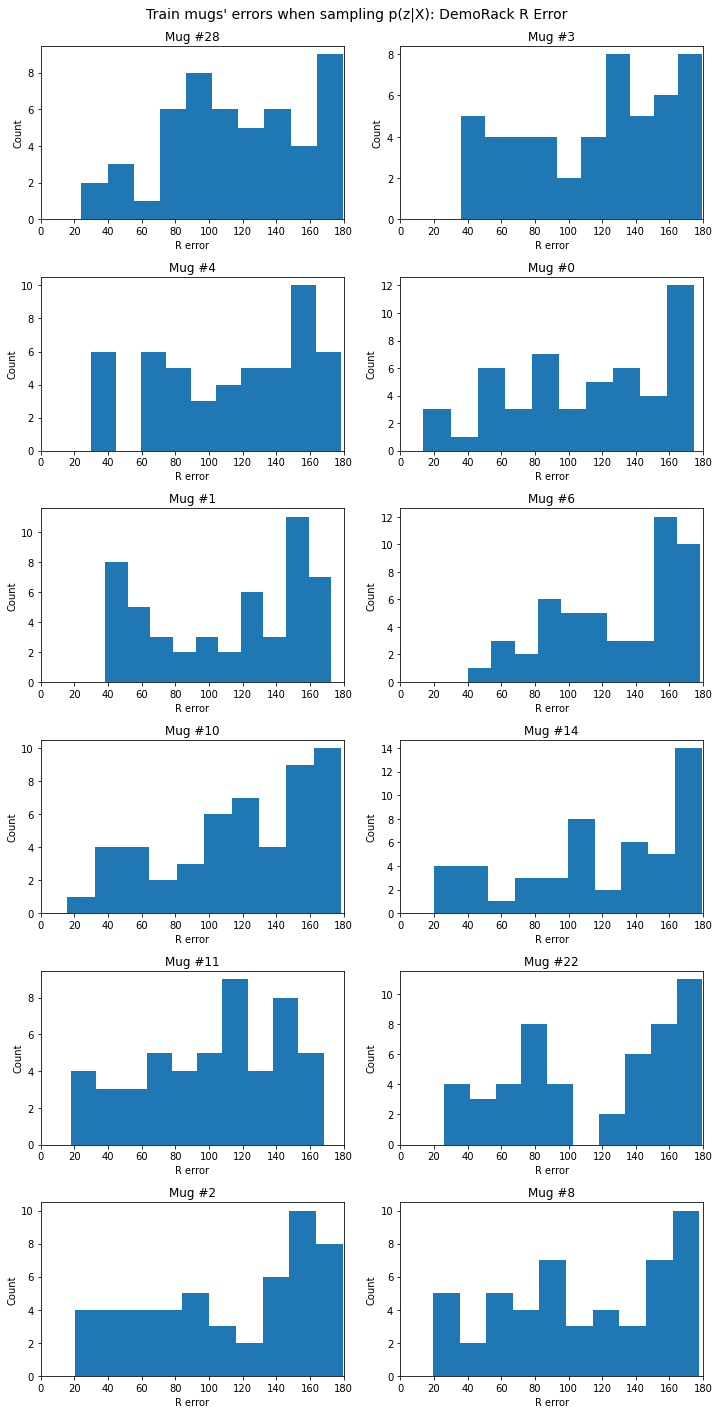

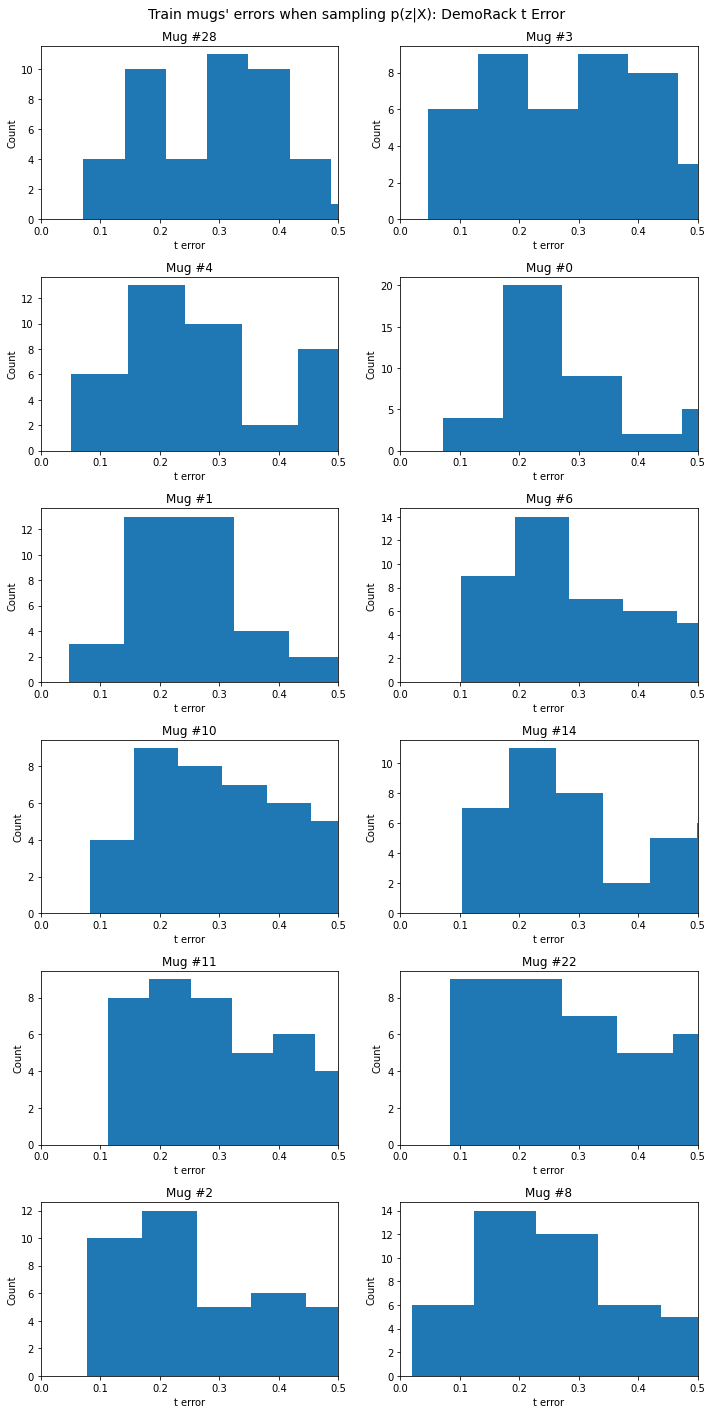

In [15]:
def plot_by_mug(configs, results, fixed_xrange=True):
    def aggregate_results_by_mug_across_metrics(results, name, metric_name):
        assert name in results, f"Run type '{name}' doesn't exist. Use any of: {list(results.keys())}"
        sample_mug_id = list(results[name].keys())[0]
        assert metric_name in results[name][sample_mug_id], f"Metric name '{metric_name}' doesn't exist. Use any of: {list(results[name][sample_mug_id].keys())}"

        data = defaultdict(list)
        for mug_id in results[name]:
            data[mug_id].extend(results[name][mug_id][metric_name])
        return data
    
    def plot_for_one_metric(all_errors, title, error_type, fixed_xrange):
        fig, axs = plt.subplots(nrows=np.ceil(len(all_errors)/2).astype(int), ncols=2)
        fig.set_figheight(20)
        fig.set_figwidth(10)

        fig.suptitle(f"{title}\n", fontsize=14)

        for i, (mug_id, errors) in enumerate(all_errors.items()):
            plot_errors(
                all_errors=errors, 
                title=f"Mug #{mug_id}",
                error_type=error_type,
                fixed_xrange=fixed_xrange,
                ax=axs[i//2][i%2],
                verbose=False,
            )
        fig.tight_layout()
    
    for config in configs:
        # results[config name][mug id][metric name] = [list of results]
        plot_for_one_metric(
            all_errors=aggregate_results_by_mug_across_metrics(results, config['name'], 'minrack_R_error'),
            title=f"{config['title']}: MinRack R Error",
            error_type="rotation",
            fixed_xrange=fixed_xrange,
        )
        plt.show()
        
        plot_for_one_metric(
            all_errors=aggregate_results_by_mug_across_metrics(results, config['name'], 'minrack_t_error'),
            title=f"{config['title']}: MinRack t Error",
            error_type="translation",
            fixed_xrange=fixed_xrange,
        )
        plt.show()
        
        plot_for_one_metric(
            all_errors=aggregate_results_by_mug_across_metrics(results, config['name'], 'demo_R_error'),
            title=f"{config['title']}: DemoRack R Error",
            error_type="rotation",
            fixed_xrange=fixed_xrange,
        )
        plt.show()
        
        plot_for_one_metric(
            all_errors=aggregate_results_by_mug_across_metrics(results, config['name'], 'demo_t_error'),
            title=f"{config['title']}: DemoRack t Error",
            error_type="translation",
            fixed_xrange=fixed_xrange,
        )
        plt.show()
        

plot_by_mug(configs, results)




# Visualizing latent z

In [69]:
fig2 = go.FigureWidget(
    make_subplots(
            column_widths=[0.5, 0.5],
            row_heights=[1],
            rows=1, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}]],
            subplot_titles=("p(z)" if not vis_train else "p(z|Y)","p(z|X)")
    )
)

action_pts_dmean = action_pts - np.concatenate([action_pts, anchor_pts], axis=0).mean(axis=0)
fig2.add_trace(
    go.Scatter3d(
        x = action_pts_dmean[:,0], 
        y = action_pts_dmean[:,1], 
        z = action_pts_dmean[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
        name='action_demo',
    ), 
    row=1, col=1
)



action_trans_pts_dmean = action_trans_pts - action_trans_pts.mean(axis=0)
fig2.add_trace(
    go.Scatter3d(
        x = action_trans_pts_dmean[:,0], 
        y = action_trans_pts_dmean[:,1], 
        z = action_trans_pts_dmean[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
        name='action_demo',
    ), 
    row=1, col=2
)

# mean_center = torch.tensor([[0, 0, 0]], device=points_action.device)
mean_center = torch.tensor(action_trans_pts.mean(axis=0), device=points_action.device)
fig2.add_trace(
    go.Scatter3d(
        x = (trans_pt_action-mean_center).detach().cpu().numpy()[0,0:1], 
        y = (trans_pt_action-mean_center).detach().cpu().numpy()[0,1:2], 
        z = (trans_pt_action-mean_center).detach().cpu().numpy()[0,2:3],
        mode = 'markers',
        hoverinfo = 'none',
        name='action_demo',
    ), 
    row=1, col=2
)

# fig2.data[0].marker.color = goal_emb_action[0,0].detach().cpu().numpy()
# big, small = F.softmax(goal_emb_action[0,0]).detach().cpu().numpy().max(), F.softmax(goal_emb_action[0,0]).detach().cpu().numpy().min()
# w = big - small
# pzy_color = F.softmax(goal_emb_action[0,0]).detach().cpu().numpy()
# pzy_color[pzy_color > small + w*0.09] = 0

# fig2.data[0].marker.color = pzy_color

goal_emb_action_colors = color_gradient(F.softmax(goal_emb_action[0], dim=-1))
goal_emb_cond_x_action_colors = color_gradient(F.softmax(goal_emb_cond_x_action[0], dim=-1))
    
fig2.data[0].marker.color = goal_emb_action_colors[0]
fig2.data[1].marker.color = goal_emb_cond_x_action_colors[0]



# fig2.data[0].marker.color = F.softmax(goal_emb_action[0,0]).detach().cpu().numpy()
# fig2.data[1].marker.color = F.softmax(goal_emb_cond_x_action[0,0]).detach().cpu().numpy()

print(f"Mug #{MUG_ID}")
fig2

Mug #72


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([[  0.,   0., 255.],…

In [90]:
action_pts_dmean[:1,0]

array([-0.17474526], dtype=float32)

In [91]:
(trans_pt_anchor+mean_center).detach().cpu().numpy()[0,0:1]

array([0.08213523], dtype=float32)

In [98]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence

fig = go.FigureWidget(
        make_subplots(
            column_widths=[0.5, 0.5],
            row_heights=[1],#[0.5, 0.5],
            rows=1, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}]],
        )
    )

fig.add_trace(
    go.Scatter3d(
        x = action_pts[:,0], 
        y = action_pts[:,1], 
        z = action_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

fig.add_trace(
    go.Scatter3d(
        x = anchor_pts[:,0], 
        y = anchor_pts[:,1], 
        z = anchor_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

fig.add_trace(
    go.Scatter3d(
        x = [-0.2], 
        y = [0.2], 
        z = [0], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)


fig.add_trace(
    go.Scatter3d(
        x = [0.1], 
        y = [0.2], 
        z = [0], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

# scatter_post_action = fig.data[-1]
# scatter_post_action.marker.size = 1
# scatter_post_action.marker.opacity = 0.5
# scatter_post_action.marker.color = '#9467bd'
# remove_background(fig)



fig

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'mode': 'markers',
              'scene': 'sce…